# California 1990 Census Housing Data

The dataset is originally from the statlib repository. I found it [here](handson-ml/datasets/housing/housing.tgz). 

The goal is to make a median housing price predictor for any given district using the available features. 

In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import tarfile
import urllib
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from IPython.display import display
%matplotlib inline

SAVE_PATH = 'dataset'
DATA_URL = 'https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.tgz'
def download_dataset(housing_url=DATA_URL,save_path=SAVE_PATH):
    if os.path.isfile(os.path.join(SAVE_PATH,'housing.csv')):
        return
    if not os.path.isdir(save_path):
        os.makedirs(save_path)
    full_save_path = os.path.join(save_path,'housing.tgz')
    urllib.request.urlretrieve(housing_url, full_save_path)
    housing_tgz = tarfile.open(full_save_path)
    housing_tgz.extractall(path=save_path)
    housing_tgz.close()

download_dataset()
        
    
data = pd.read_csv('dataset/housing.csv')
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [21]:
#207 missing fields in total_bedrooms
display(data.isnull().sum())

#ocean_proximity isn't a number, that'll need to be converted to be usable.
data.info()
#total_rooms and total_bedrooms both have much high values than one would expect. After looking at the 
#documentation, looks like it's the total number of rooms in the district, not per household. I'm going
#to convert them into 'per household' features, to see if there's a better correlation after. 
data.describe()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5019c86240>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f5019abd2b0>]], dtype=object)

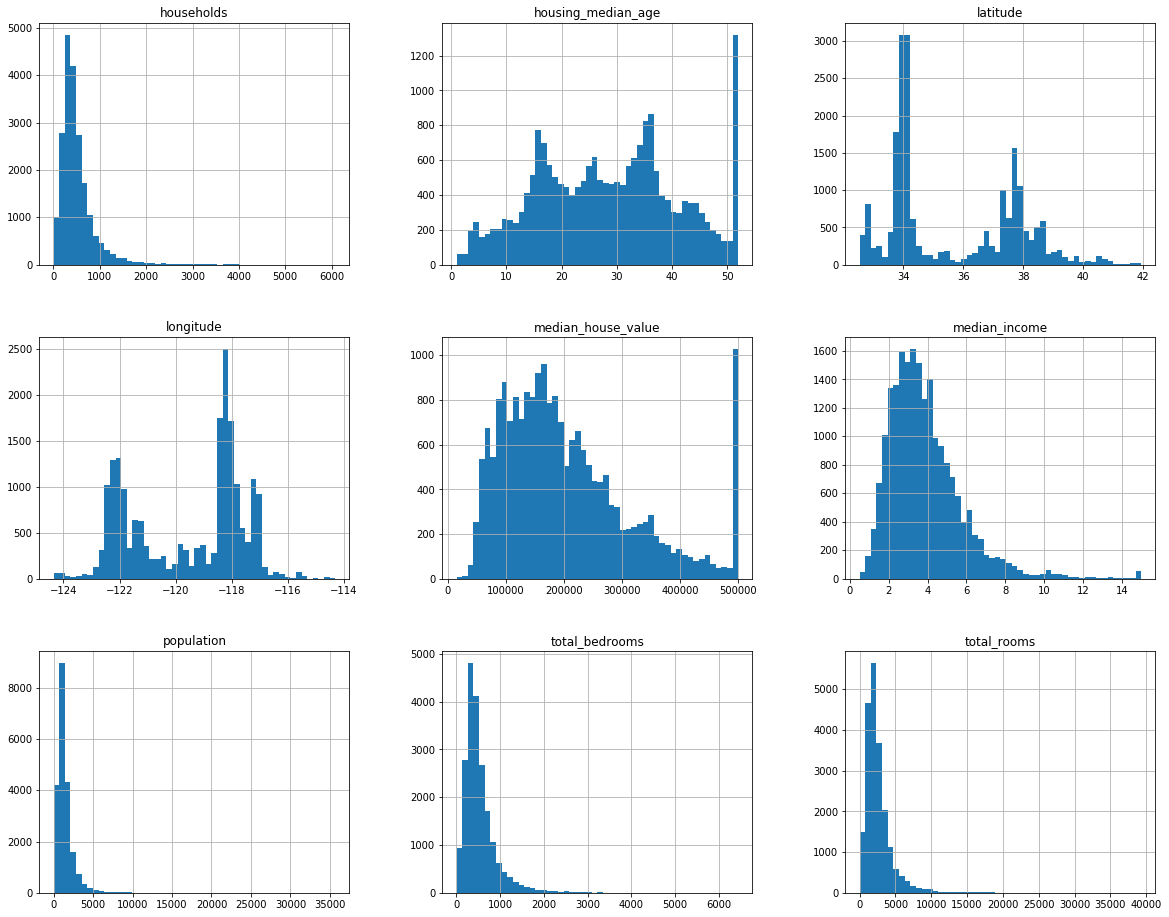

In [22]:
data.hist(bins=50,figsize=(20,16))

In [23]:
data.median_house_value.value_counts().iloc[:20]

500001.0    965
137500.0    122
162500.0    117
112500.0    103
187500.0     93
225000.0     92
350000.0     79
87500.0      78
275000.0     65
150000.0     64
175000.0     63
100000.0     62
125000.0     56
67500.0      55
250000.0     47
200000.0     46
118800.0     39
450000.0     37
156300.0     35
212500.0     33
Name: median_house_value, dtype: int64

The median house value is the target column, and there's some pretty obvious value capping for values higher than $500,000. Give that that's the feature column, I'm going to drop those rows to keep from skewing the results. There's also some apparent value capping in median house age, any house older than 52 years seems to be capped at that value. 

All of the rest of the distributions are skewed negative, it might be worth going with the log instead to get a more normal distribution. I'll try both out and see if it improves model performance. 

The median income column has some strange values. Looks like it's been pre-scaled. 

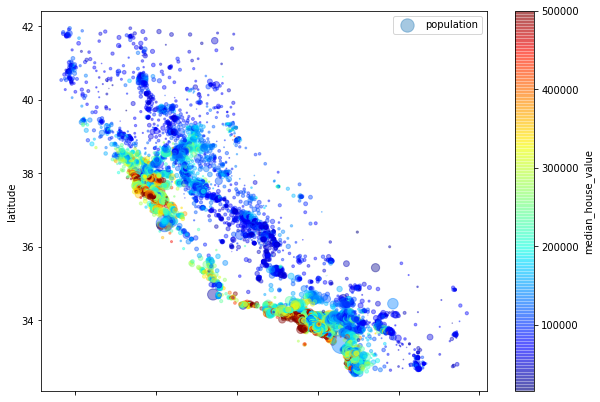

In [47]:
data.plot(kind='scatter',x='longitude',y='latitude',alpha=.4,s=data.population/100, label='population',c='median_house_value',cmap=plt.get_cmap('jet'),colorbar=True,figsize=(10,7))

In [25]:
data.corr()['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

looks like it gets cheaper as you go north, and the median income is the most highly correlated feature. Let's try cleaning up the total rooms and total bedrooms features to be per house instead of per district. First I'm going to take a closer look at the two most highly correlated features. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f50194562e8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f50192f3518>]], dtype=object)

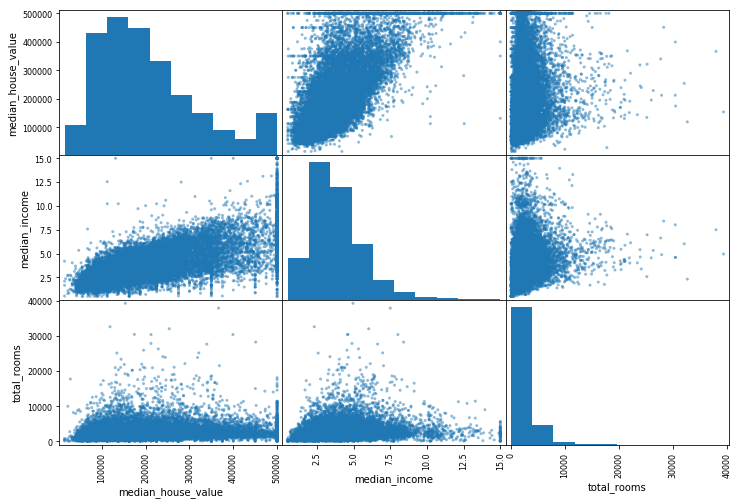

In [26]:
attributes = ['median_house_value','median_income','total_rooms']
scatter_matrix(data[attributes],figsize=(12,8))

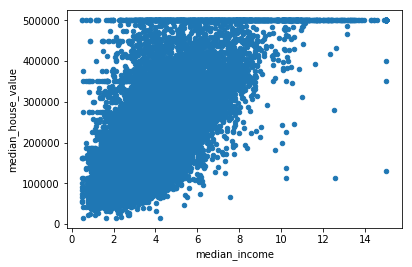

In [27]:
data.plot(kind='scatter',x='median_income',y='median_house_value')

In the scatter matrixes, it looks like there's some value capping going on in some smaller districts too, might be worth cleaning those rows as well. Now, let's add some new features. I'm going to add population per household too to see if that correlates at all. 

In [28]:
x = data.copy()
x['rooms_per_household'] = x['total_rooms']/x['households']
x['bedrooms_per_room'] = x['total_bedrooms']/x['total_rooms']
x['population_per_household'] = x['population']/x['households']
x.corr()['median_house_value'].abs().sort_values(ascending=False)

median_house_value          1.000000
median_income               0.688075
bedrooms_per_room           0.255880
rooms_per_household         0.151948
latitude                    0.144160
total_rooms                 0.134153
housing_median_age          0.105623
households                  0.065843
total_bedrooms              0.049686
longitude                   0.045967
population                  0.024650
population_per_household    0.023737
Name: median_house_value, dtype: float64

Bedrooms per room and rooms per household both look like worthwhile features to include, or at least to test. 

## Create a Data Cleaning Pipeline

I created 3 custom classes to help with the cleaning pipeline. One to create the new features I selected as being worth investigating, one so I can pass dataframes into the pipeline (sklearn natively only supports numpy matrixes) and one to account for the fact that LabelBinarizer doesn't fit into the Pipeline with the way it's implemented in the current version of sklearn.

In [43]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelBinarizer

#getting rid of the capped values, then pulling out the target column
X = data[data.median_house_value != 500001.0]
y = data.median_house_value
X = X.drop(['median_house_value'],axis=1)

idx_bedrooms = X.columns.get_loc('total_bedrooms')
idx_rooms = X.columns.get_loc('total_rooms')
idx_households = X.columns.get_loc('households')

class CombinedAttributesAddr(BaseEstimator, TransformerMixin):
    def __init__(self,add_rooms_per_household=True):
        self.add_rooms_per_household = add_rooms_per_household
        global idx_bedrooms
        global idx_rooms
        global idx_households
        self.idx_bedrooms = idx_bedrooms
        self.idx_rooms = idx_rooms
        self.idx_households = idx_households
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):        
        bedrooms_per_room = X[:,idx_bedrooms] / X[:,idx_rooms]
        if self.add_rooms_per_household:
            rooms_per_household = X[:,idx_rooms] / X[:,idx_households]
            return np.c_[X, rooms_per_household, bedrooms_per_room]
        else: return np.c_[X, bedrooms_per_room]
        

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
    

class LabelBinarizer_new(TransformerMixin, BaseEstimator):
    def fit(self, X, y = None):
        return self
    def transform(self, X, y = 0):
        encoder = LabelBinarizer()
        result = encoder.fit_transform(X)
        return result
    

In [44]:
num_cols = X.columns.drop('ocean_proximity')
cat_cols = ['ocean_proximity']

display(num_cols)
display(cat_cols)

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import Imputer

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_cols)),
    ('imputer', Imputer(strategy='median')),
    ('attribute_addr', CombinedAttributesAddr()),
    ('std_scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_cols)),
    ('label_binarizer', LabelBinarizer_new()),
])

full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline',num_pipeline),
    ('cat_pipeline',cat_pipeline),
])

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype='object')

['ocean_proximity']

In [45]:
data_prepared = full_pipeline.fit_transform(X)
data_prepared.shape



(19675, 15)

In [46]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
lr = LinearRegression()
lr.fit(data_prepared,y)

predictions = lr.predict(data_prepared)
mse = mean_squared_error(predictions,y)
rmse = np.sqrt(mse)
rmse

ValueError: Found input variables with inconsistent numbers of samples: [19675, 20640]

In [12]:
#splitting up into train and test sets.
#import matplotlib.pyplot as plt
#from sklearn.model_selection import train_test_split
#X = data[data.columns.drop('median_house_value')]
#y = data.median_house_value
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)